In [1]:
import pandas as pd

df = pd.read_csv('../data/twitter_dataset.csv')
print(df.columns)
df.head()

Index(['clean_text', 'category'], dtype='object')


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

In [3]:
imdb = tf.keras.datasets.imdb
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

# Get word index
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Function to decode reviews
def decode_review(text):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in text])

# Display some information
print(f"Training samples: {len(x_train)}")
print(f"Testing samples: {len(x_test)}")
print(f"Number of unique words: {len(word_index)}")
print(f"Example review: {decode_review(x_train[0])}")
print(f"Label: {y_train[0]}")

,text,sentiment,cleaned_text
0,when modi promised “minimum government maximum...,-1.0,modi promised minimum government maximum gover...
1,talk all the nonsense and continue all the dra...,0.0,talk nonsense continue drama vote modi
2,what did just say vote for modi welcome bjp t...,1.0,say vote modi welcome bjp told rahul main camp...
3,asking his supporters prefix chowkidar their n...,1.0,asking supporters prefix chowkidar names modi ...
4,answer who among these the most powerful world...,1.0,answer among powerful world leader today trump...


In [4]:
max_length = 500  # Maximum sequence length
x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

print(f"Training data shape: {x_train.shape}")
print(f"Testing data shape: {x_test.shape}")

Unique sentiment values: [-1.  0.  1.]
Sentiment distribution:
sentiment
 1.0    72250
 0.0    55213
-1.0    35510
Name: count, dtype: int64
Final label distribution:
label
2    72250
1    55213
0    35510
Name: count, dtype: int64
Label mapping verification:
  -1.0 -> 0.0
  0.0 -> 1.0
  1.0 -> 2.0


In [5]:

# If you have a CSV file with 'text' and 'sentiment' columns
df = pd.read_csv('sentiment_data.csv')
print(f"Dataset shape: {df.shape}")
print(df.head())
print(df['sentiment'].value_counts())

# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Apply preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

# Pad sequences
max_length = 500
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Prepare labels
label_mapping = {'positive': 1, 'negative': 0}  # Adjust based on your labels
y = df['sentiment'].map(label_mapping)

# Split data
x_train, x_test, y_train, y_test = train_test_split(
    padded_sequences, y, test_size=0.2, random_state=42, stratify=y
)


In [23]:
def create_lstm_model(vocab_size, embedding_dim, max_length, lstm_units=64):
    model = Sequential([
        # Embedding layer
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        
        # Spatial dropout for regularization
        SpatialDropout1D(0.2),
        
        # LSTM layer with dropout
        LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2),
        
        # Dense layers
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    return model
# Model parameters
vocab_size = 10000
embedding_dim = 100
lstm_units = 64

# Create model
model = create_lstm_model(vocab_size, embedding_dim, max_length, lstm_units)

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

In [7]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Model checkpoint to save best model
checkpoint = ModelCheckpoint(
    'best_lstm_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

callbacks = [early_stopping, checkpoint]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
print("Starting training...")
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(x_test, y_test),
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

Class weights: {0: np.float64(1.5298272787008353), 1: np.float64(0.983910648252962), 2: np.float64(0.7518915801614764)}
Epoch 1/15
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 142s 138ms/step - accuracy: 0.3796 - loss: 1.1257 - val_accuracy: 0.5749 - val_loss: 0.9566 - learning_rate: 0.0010
Epoch 2/15
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 138s 136ms/step - accuracy: 0.4803 - loss: 0.9985 - val_accuracy: 0.5319 - val_loss: 1.0227 - learning_rate: 0.0010
Epoch 3/15
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 142s 140ms/step - accuracy: 0.4768 - loss: 0.9904 - val_accuracy: 0.7020 - val_loss: 0.7513 - learning_rate: 0.0010
Epoch 4/15
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 135s 133ms/step - accuracy: 0.6156 - loss: 0.8073 - val_accuracy: 0.7054 - val_loss: 0.7400 - learning_rate: 0.0010
Epoch 5/15
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 141s 138ms/step - accuracy: 0.6097 - loss: 0.7498 - val_accuracy: 0.6218 - val_loss: 0.6575 - learning_rate: 0.0010
Epoch 6/15
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 138s 135ms/step - accuracy: 0.6398 - loss: 0.700

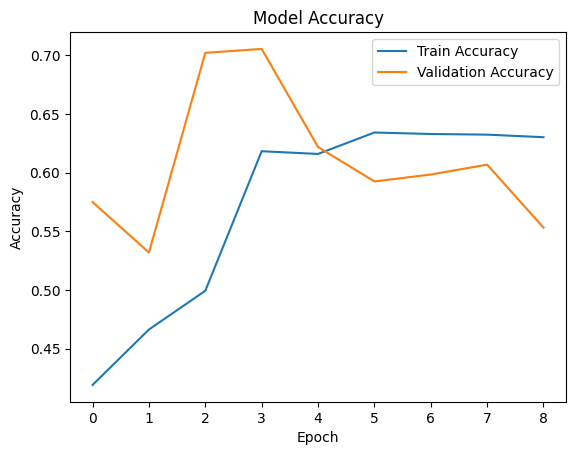

In [9]:
# Load best model
model.load_weights('best_lstm_model.h5')

# Make predictions
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary, target_names=['Negative', 'Positive']))

In [10]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [11]:
def predict_sentiment(text, model, tokenizer=None):
    # If using IMDB dataset (no custom tokenizer)
    if tokenizer is None:
        # For IMDB dataset, we need to convert text to sequences manually
        word_index = tf.keras.datasets.imdb.get_word_index()
        
        # Preprocess text
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        words = text.split()
        
        # Convert to sequence
        sequence = []
        for word in words:
            if word in word_index:
                sequence.append(word_index[word] + 3)  # Add 3 for reserved indices
            else:
                sequence.append(2)  # OOV token
        
        # Pad sequence
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post', truncating='post')
    else:
        # For custom dataset with tokenizer
        sequence = tokenizer.texts_to_sequences([text])
        sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    
    # Make prediction
    prediction = model.predict(sequence)[0][0]
    
    # Interpret result
    if prediction > 0.5:
        return f"Positive sentiment (confidence: {prediction:.2f})"
    else:
        return f"Negative sentiment (confidence: {1-prediction:.2f})"

=== TESTING PREDICTIONS ===
Original text: 'I absolutely love this product!'
Cleaned text: 'absolutely love product'
Sequence: [[843, 165, 2749]]
Prediction probabilities: [0.43349585 0.00600177 0.56050235]
Predicted class: 2
Confidence: 0.561
Final Result: Positive (Confidence: 0.561)
--------------------------------------------------
Original text: 'It was terrible and boring.'
Cleaned text: 'terrible boring'
Sequence: [[4176, 5979]]
Prediction probabilities: [0.4234016  0.00673699 0.56986135]
Predicted class: 2
Confidence: 0.570
Final Result: Positive (Confidence: 0.570)
--------------------------------------------------
Original text: 'It's fine, not too bad.'
Cleaned text: 'fine bad'
Sequence: [[1212, 284]]
Prediction probabilities: [0.42479357 0.00623687 0.56896955]
Predicted class: 2
Confidence: 0.569
Final Result: Positive (Confidence: 0.569)
--------------------------------------------------
Original text: 'This is amazing and wonderful!'
Cleaned text: 'amazing wonderful'
Sequ

In [12]:
def create_advanced_lstm_model(vocab_size, embedding_dim, max_length):
    model = Sequential([
        # Embedding layer
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        
        # Spatial dropout
        SpatialDropout1D(0.3),
        
        # Bidirectional LSTM layers
        tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True, dropout=0.3)),
        tf.keras.layers.Bidirectional(LSTM(32, dropout=0.3)),
        
        # Dense layers with batch normalization
        Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        Dropout(0.5),
        
        Dense(32, activation='relu'),
        Dropout(0.3),
        
        Dense(1, activation='sigmoid')
    ])
    
    return model

# Uncomment to use advanced model

advanced_model = create_advanced_lstm_model(vocab_size, embedding_dim, max_length)
advanced_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
advanced_model.summary()



=== MODEL EVALUATION ===
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.29      0.06      0.10      7102
     Neutral       0.82      0.95      0.88     11043
    Positive       0.66      0.84      0.74     14450

    accuracy                           0.71     32595
   macro avg       0.59      0.62      0.57     32595
weighted avg       0.63      0.71      0.65     32595


Confusion Matrix:
[[  417   943  5742]
 [   50 10500   493]
 [  974  1401 12075]]

Prediction Distribution:
Class 0 (Negative): 1441 predictions (4.4%)
Class 1 (Neutral): 12844 predictions (39.4%)
Class 2 (Positive): 18310 predictions (56.2%)


In [13]:
model.save('sentiment_lstm_model.h5')
print("Model saved successfully!")

label
2    72250
1    55213
0    35510
Name: count, dtype: int64

In [14]:
def analyze_model_performance(model, x_test, y_test):
    predictions = model.predict(x_test)
    pred_binary = (predictions > 0.5).astype(int)
    
    # Calculate various metrics
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
    
    accuracy = accuracy_score(y_test, pred_binary)
    precision = precision_score(y_test, pred_binary)
    recall = recall_score(y_test, pred_binary)
    f1 = f1_score(y_test, pred_binary)
    auc = roc_auc_score(y_test, predictions)
    
    print("Model Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

label
2    72250
1    55213
0    35510
Name: count, dtype: int64

In [15]:
# Analyze performance
performance_metrics = analyze_model_performance(model, x_test, y_test)

love
